In [6]:
import os   #used for directory work
import matplotlib.patches as mpatches #used for plot legends
import matplotlib.pyplot as plt #used for creating plots
import matplotlib.cm as cm
import pandas as pd
import numpy as np
%matplotlib inline

In [7]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/" #79 location
path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/"  #134 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/" #w10 location
def text_finder(path):
    txt_files=[]
    all_files = os.listdir(path) #tells what directory the files are in
    for i in all_files: #reading only the .txt files 
        if i[-4:] == ".txt":
            txt_files.append(i)
    txt_files.sort() #alphabetizes them
    return txt_files

txt_files = text_finder(path)
df = pd.read_csv(path + txt_files[0],na_values = ['NAN', "00nan"], sep="\t")  



FileNotFoundError: [WinError 3] The system cannot find the path specified: '/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/'

In [28]:

def calculations(df,n):
    timestamp_lst, speed = [],[]
    for t in range(len(df)):
        timestamp_lst.append(pd.Timestamp(str(df["YYYY"][t])+"-"+str(df["MM"][t])+"-"+str(df["DD"][t]) +" "+str(df["Hr"][t])+":"+str(df["Min"][t])+":"+str(df["Sec"][t]),freq = ".1S"))
        speed.append(np.sqrt((df["U"][t])**2+(df["V"][t])**2))

    df_raw = pd.DataFrame()
    df_raw["Timestamp"] = timestamp_lst
    df_raw["W"]=df["W"]
    df_raw["S"]=speed
    df_raw["T"]= df["T"]
    #### Calculating the W', T' averages

    W_average = np.mean(df["W"][:n])
    S_average = np.mean(df_raw["S"][:n])

    W_prime, S_prime= [], []
    for i in range(len(df)):
        W_prime.append(df["W"][i]-W_average)
        S_prime.append(df_raw["S"][i]-S_average)

    ### Making the Quad list for all the points
    quad = [] 
    for i in range(len(df_raw)):
        if float(W_prime[i]) > 0 and float(S_prime[i]) > 0:
            quad.append(1)
            continue
        if float(W_prime[i]) > 0 and float(S_prime[i]) < 0:
            quad.append(2)
            continue
        if float(W_prime[i]) < 0 and float(S_prime[i]) < 0:
            quad.append(3)
            continue
        if float(W_prime[i]) < 0 and float(S_prime[i]) > 0:
            quad.append(4)
            continue
        else:
            quad.append(0)


    df_raw["Quad"] = quad
    df_raw = df_raw.set_index("Timestamp")
    time_steps = "10s"

    n_per_10s=list(df_raw.resample(time_steps).count()["W"])

    counter = 0
    q1_list, q2_list = [], []
    q3_list, q4_list = [], []
    for a in n_per_10s:
        if a ==0:
            q1_list.append(0)
            q2_list.append(0)
            q3_list.append(0)
            q4_list.append(0)
            continue
        else:
            q1_list.append((6*quad[counter:int(a+counter)].count(1))/a)
            q2_list.append(-6*(quad[counter:int(a+counter)].count(2))/a)#
            q3_list.append((6*quad[counter:int(a+counter)].count(3))/a)
            q4_list.append(-6*(quad[counter:int(a+counter)].count(4))/a)#

            counter = counter + int(a)

    ## W'T' 
    ws = []
    for i in range(len(df)):
        ws.append(W_prime[i]*S_prime[i])

    df_prime = pd.DataFrame()
    df_prime["Timestamp"] = timestamp_lst
    df_prime["W'S'"]= ws
    df_prime = df_prime.set_index("Timestamp")

    df_plot = df_prime.resample(time_steps).mean()

    q3_bottom, q4_bottom = [],[]
    for i in range(len(list(df_plot["W'S'"]))):
        q3_bottom.append(q1_list[i]+list(df_plot["W'S'"])[i])
        q4_bottom.append(q2_list[i]+list(df_plot["W'S'"])[i])

    x_tick_loc, x_tick_label = [], []
    for i in range(0,len(df_plot),len(df_plot)//5):
        x_tick_loc.append(i)
        x_tick_label.append(str(df_plot.index[i])[-9:])

    x = np.arange(0, len(q1_list), 1)
    
    #Calculating the time of fire for each sonic
    T_resample = list(df_raw.resample(time_steps).mean()["T"])
    x_fire = 0
    for i in range(len(T_resample)):
        if T_resample[i] > (np.mean(T_resample)+6*np.std(T_resample)):
            x_fire = i+.5 
            break

    return x,x_fire, df_plot, q1_list, q2_list, q3_list, q4_list,x_tick_loc, x_tick_label,q3_bottom,q4_bottom

In [29]:
#plt.figure(figsize=(20,12))
#plt.bar(x,q1_list,color="b", label = "I",bottom = list(df_plot["W'T'"]))
#plt.bar(x,q2_list, color="orange", label = "II",bottom = list(df_plot["W'T'"]))
#plt.bar(x,q3_list, color="g", label = "III",bottom= q3_bottom)
#plt.bar(x,q4_list,color="r" , label = "IV",bottom = q4_bottom)
#plt.vlines(n/100,55,-10)
#plt.legend(handels= ["I","II","III","IV"], labels = ["I","II","III","IV"],loc = 1,ncol=2)
#plt.legend(labels = ["III","IV"],loc = 4)
#plt.ylabel(r"$\overline{W {}'$ T${}'}$ $(\frac{m}{s}\cdot {K})$")
#plt.ylim(-.1,1.1)


In [32]:
#seperator = ""
def grid(path,n,burn,ymax=55,ymin=-10,seperator = " "):
    fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(28,16))#, sharex=True, sharey=True)
    txt_files = text_finder(path)
    file=0
    for col in range(4):
        for row in range(4):
            #read in the data and compute means
            df = pd.read_csv(path + txt_files[file],na_values = ['NAN', "00nan"], sep=seperator)  
            x,x_fire,df_plot, q1_list, q2_list, q3_list, q4_list,x_tick_loc, x_tick_label,q3_bottom,q4_bottom = calculations(df,n)
            #create the scatter subplots
            ax = axs[ col, row]

            ax.plot(list(df_plot["W'S'"]), marker = "_",linewidth=.3,linestyle = "--", c = "k", markersize=.25)
            ax.bar(x,q2_list,width = .8,label = "II",color = "indianred",bottom =list(df_plot["W'S'"]))
            ax.bar(x,q3_list,width = .8,label = "III",color = "limegreen",bottom =q3_bottom)
            ax.bar(x,q1_list, width = .8,label = "I",color="royalblue",bottom =list(df_plot["W'S'"]))
            ax.bar(x,q4_list, width = .8,label = "IV",color = "orange",bottom =q4_bottom)
            ax.legend(ncol = 2,title="Quadrant",loc='upper center', bbox_to_anchor=(0.2, 1.03), fontsize = 12,framealpha=0.3, markerscale = .7)
            
            ax.vlines(n/100-.5,ymin,ymax , color = "c",label =r"$\overline{PreBurn}$", linestyle = "--",linewidth = .5)
            ax.vlines(x_fire, ymin,ymax , color = "darkred",label ="($T{}'$ $+6\sigma$)", linestyle = "--",linewidth = .5)
            
            #titles and formating 
            ax.set_title(txt_files[file][:2], fontsize = 14)
            ax.set_xlabel("Time", fontsize=12)
            ax.set_ylabel(r"$\overline{W{}' S{}'}$ $(\frac{m}{s}\cdot {K})$",rotation =90, fontsize=12,labelpad=0 )
            ax.set_ylim(ymin,ymax)
            ax.set_xlim(0, len(q1_list))
            ax.set_xticks(x_tick_loc)
            ax.set_xticklabels(x_tick_label)
            #ax.legend(ncol = 2,labels = ["I","II","III","IV"],title="Quadrant",loc='upper center', bbox_to_anchor=(0.12, 1.03), fontsize = 12,framealpha=0.3, markerscale = .7)
            file=file+1 #used to change the files
            
    #adjust the spacingof the plots 
    plt.subplots_adjust(hspace=.4,wspace=.3)       
    fig.suptitle(burn+' Vertical Flux of Horizontal Momentum', fontsize = 22, x=0.5, y=0.92)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles[:2], labels[:2], loc= 'upper right',bbox_to_anchor=(.85, .94),ncol = 2, fontsize = 20)
    fig.savefig(burn+"Vertical Flux of Horizontal Momentum-Grid.png",dpi=450)

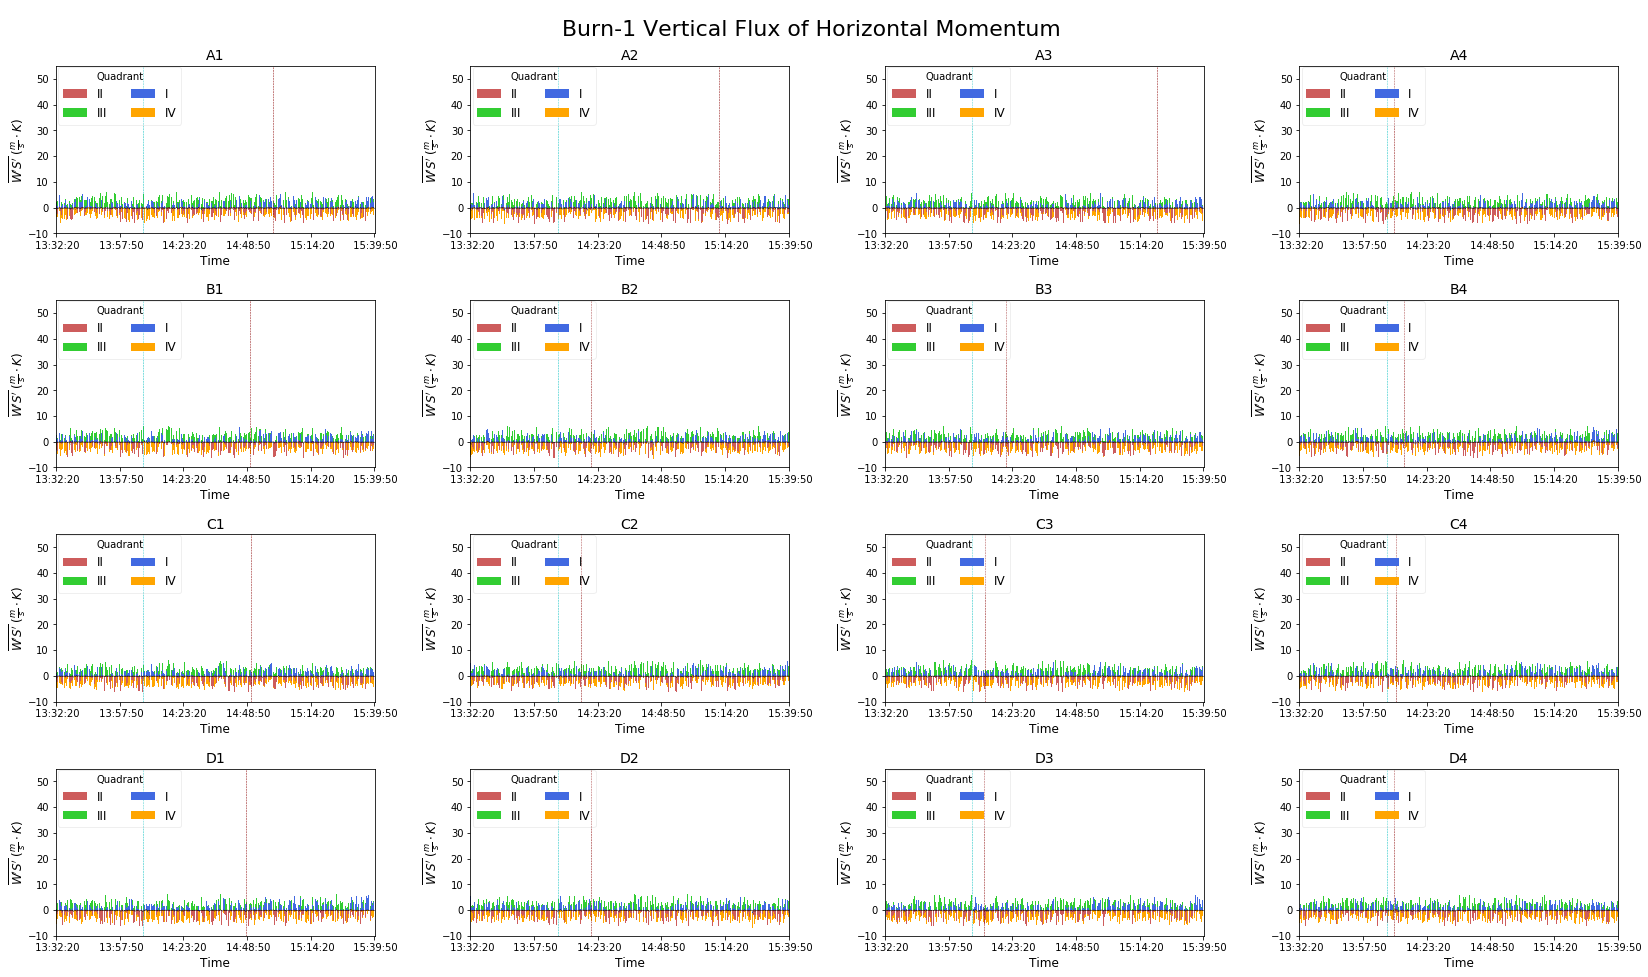

In [33]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-1/sonics/" #79 location
path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-1/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-1/sonics/"  #134 location
grid(path,21000,"Burn-1",seperator = "\t")

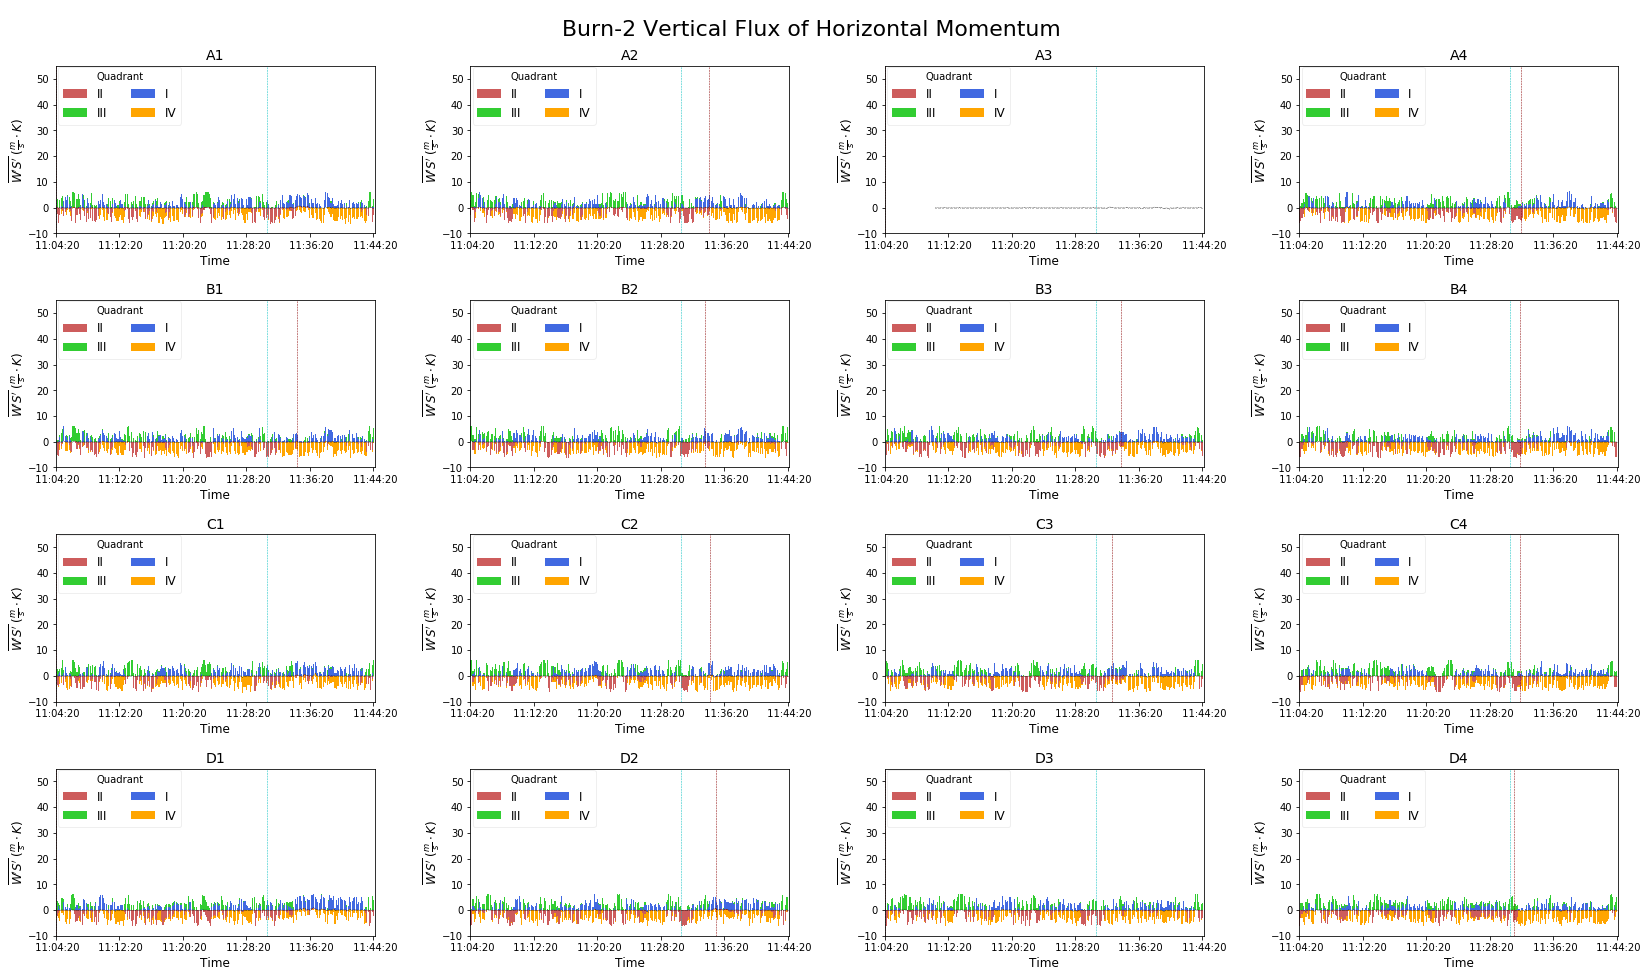

In [34]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/" #79 location
path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/"  #134 location
grid(path,16000,"Burn-2",seperator ="\t")

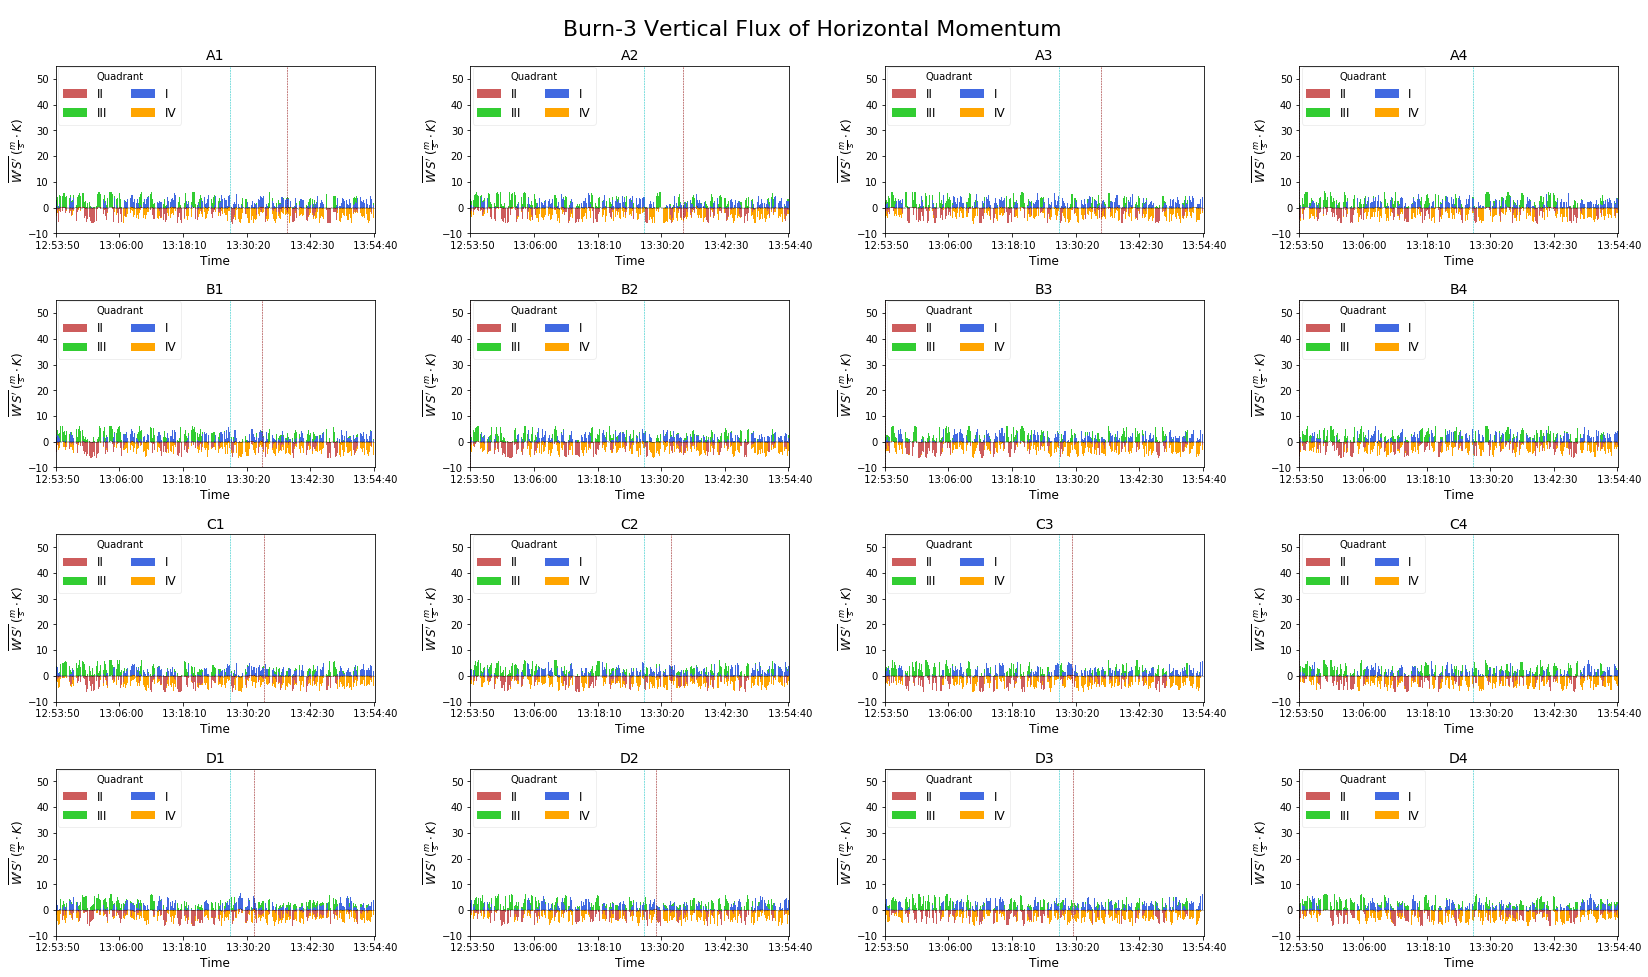

In [36]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-3/sonics/" #79 location
path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-3/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-3/sonics/"  #134 location
grid(path,20000,"Burn-3",seperator ="\t")

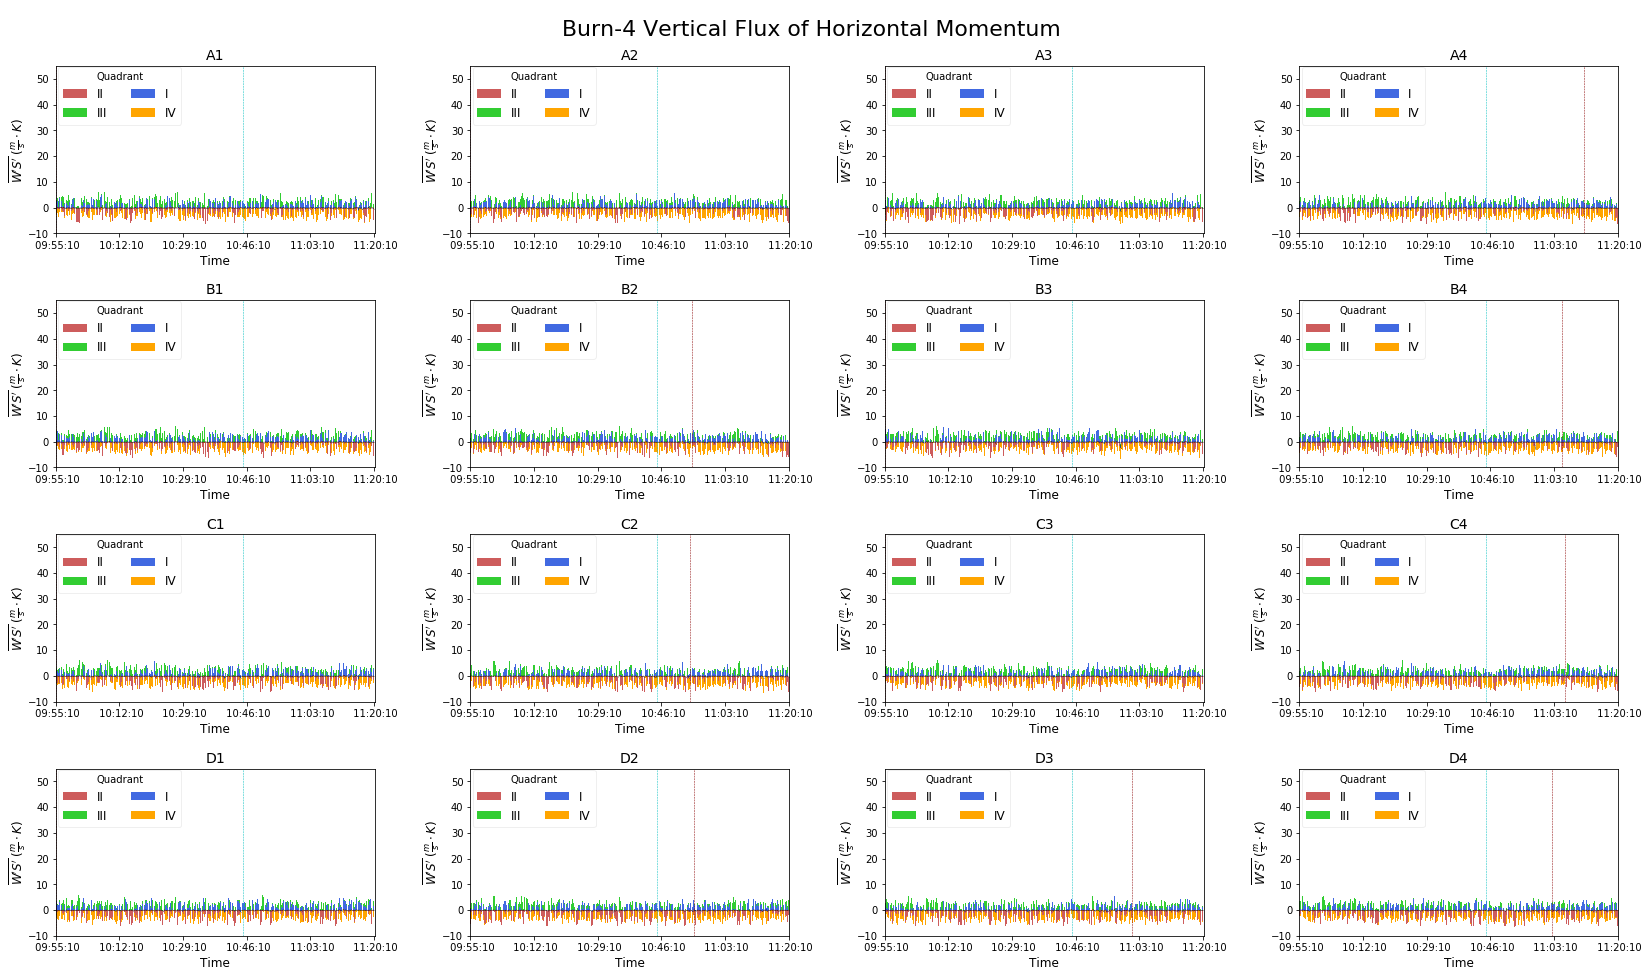

In [37]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-4/sonics/" #79 location
path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-4/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-4/sonics/"  #134 location
grid(path,30000,"Burn-4",seperator ="\t")

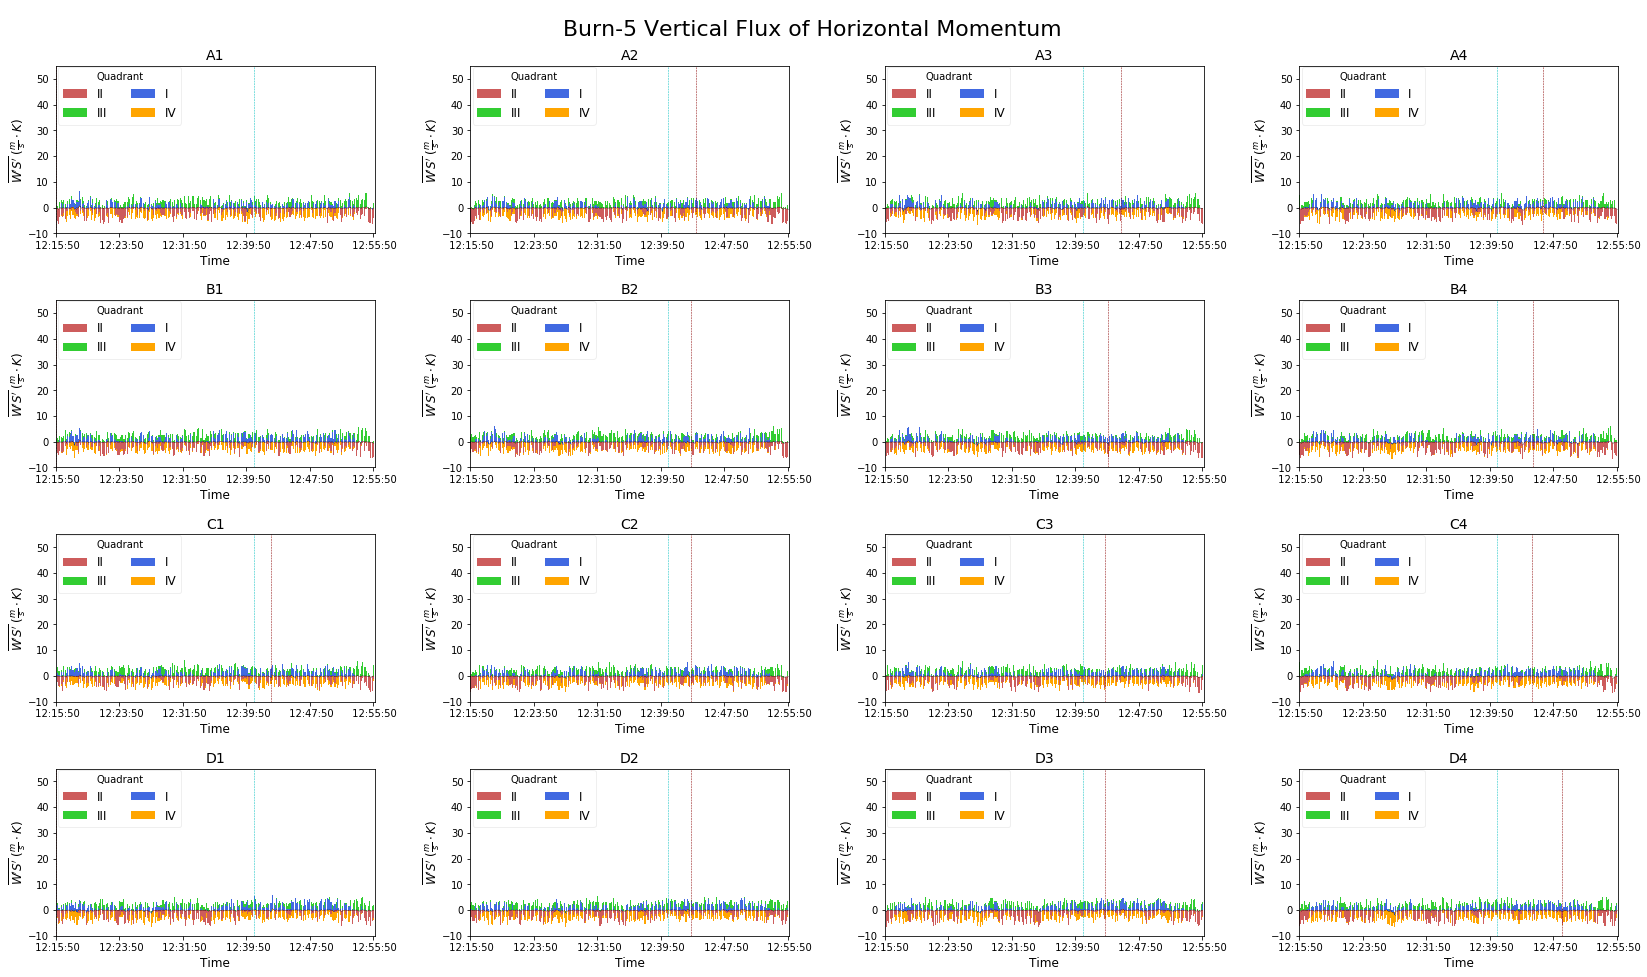

In [38]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-5/sonics/" #79 location
path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-5/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-5/sonics/"  #134 location
grid(path,15000,"Burn-5",seperator ="\t")

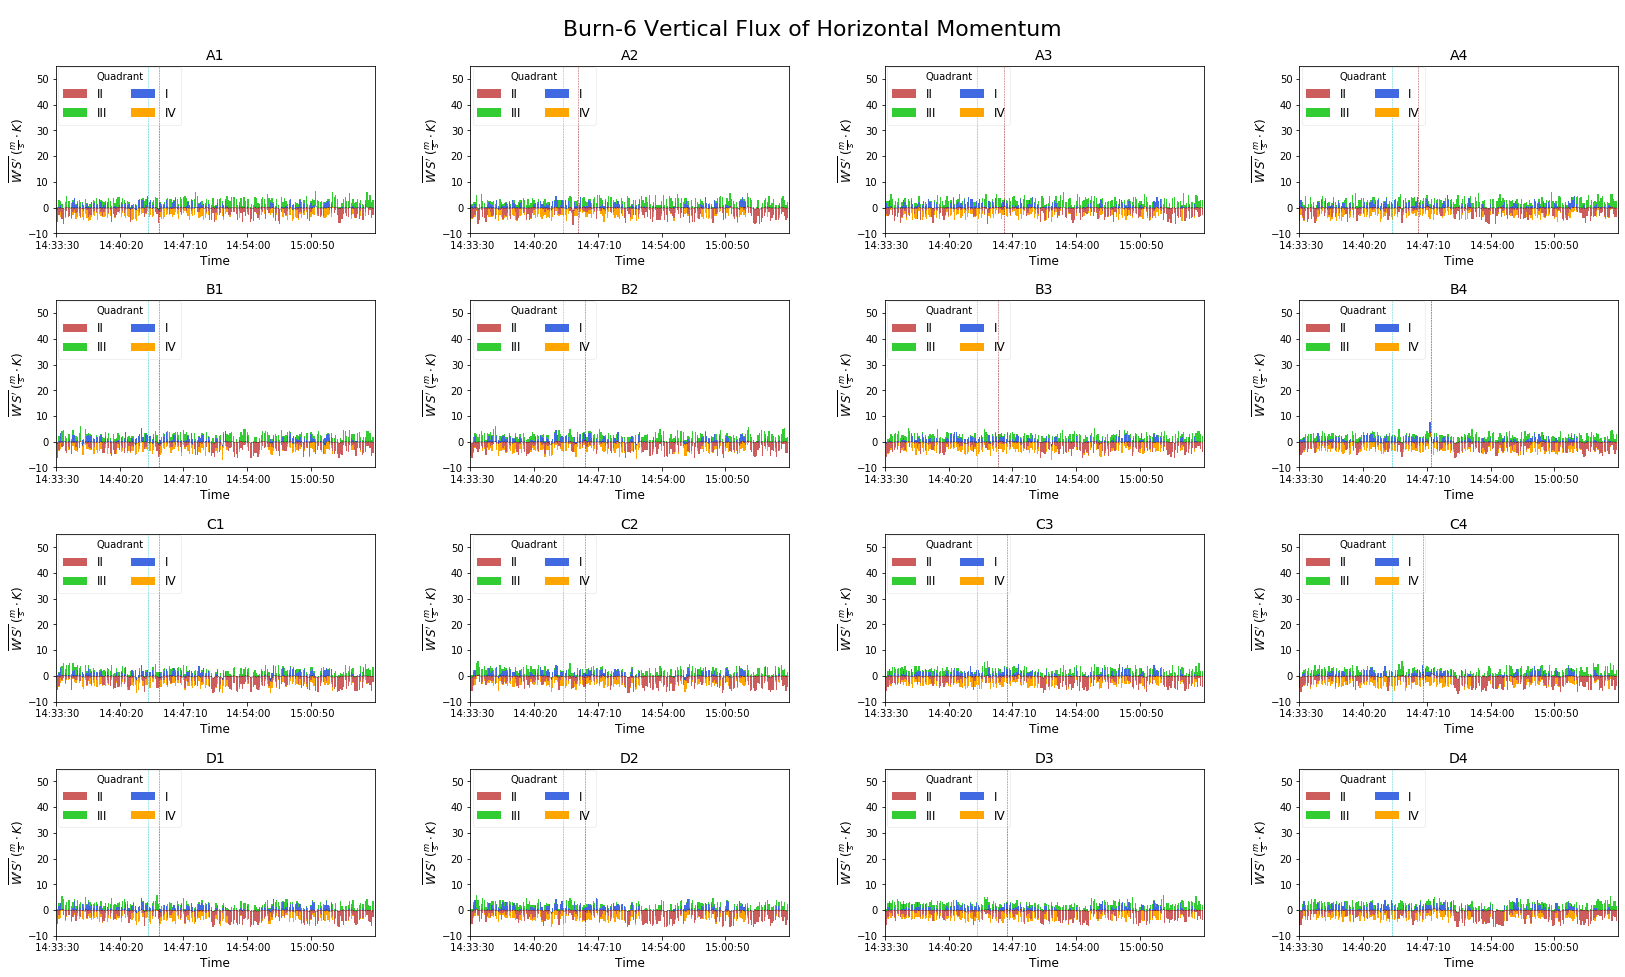

In [39]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-6/sonics/" #79 location
path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-6/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-6/sonics/"  #134 location
grid(path,6000,"Burn-6",seperator ="\t")

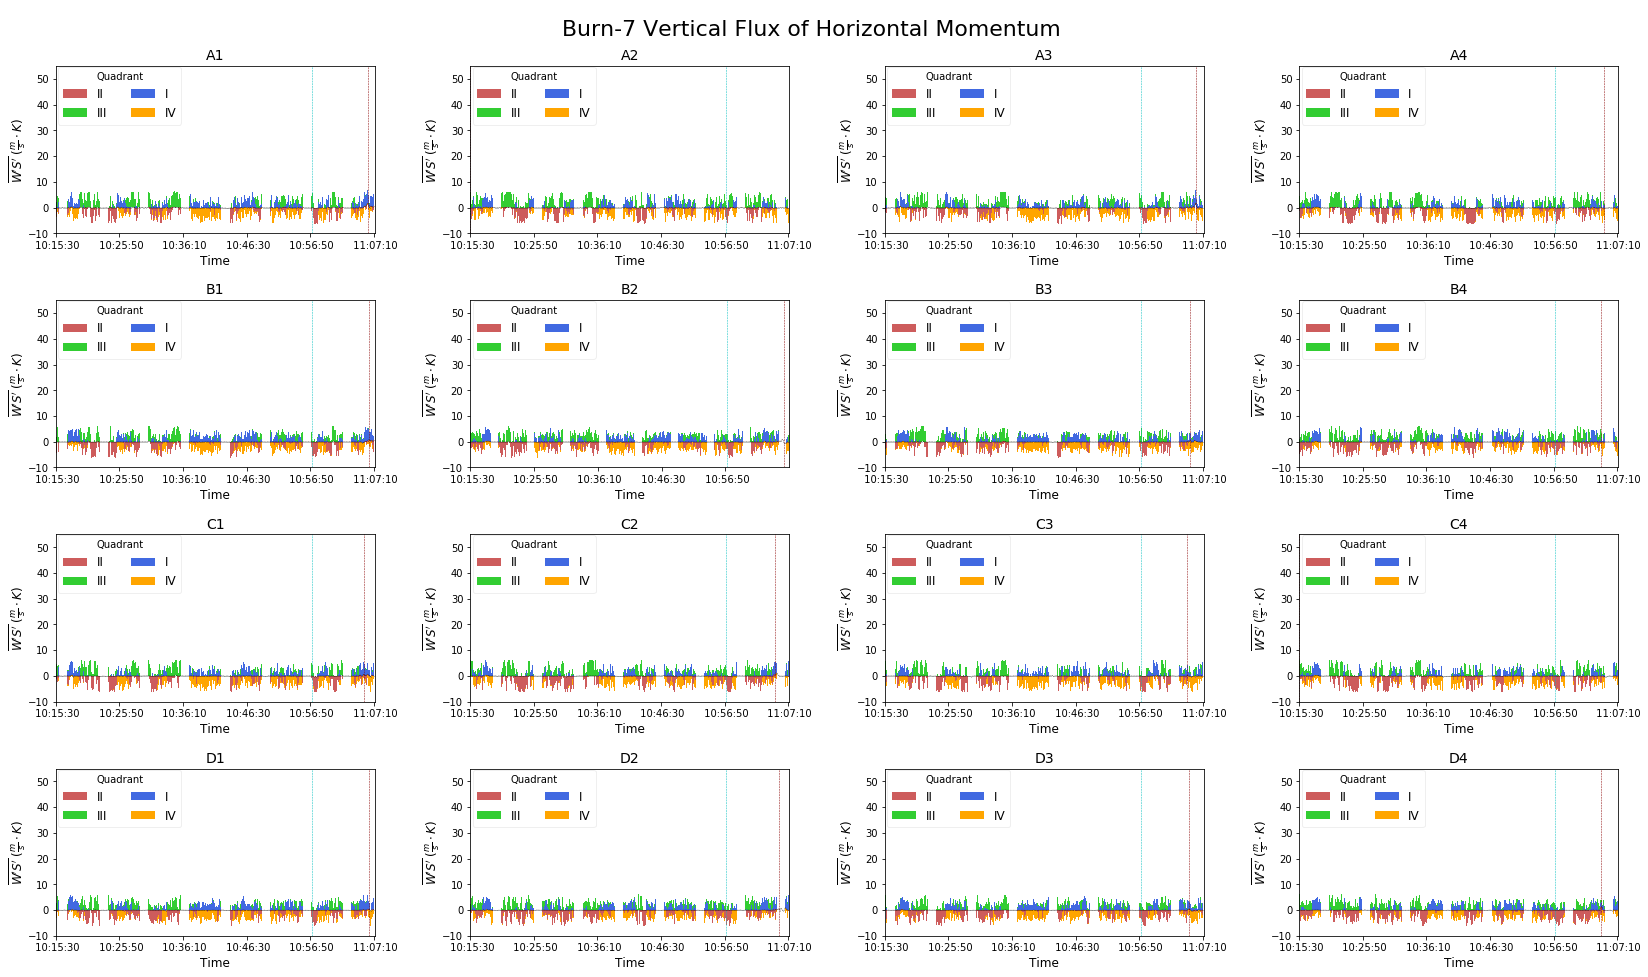

In [40]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-7/sonics/" #79 location
path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-7/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-7/sonics/"  #134 location
grid(path,25000,"Burn-7")

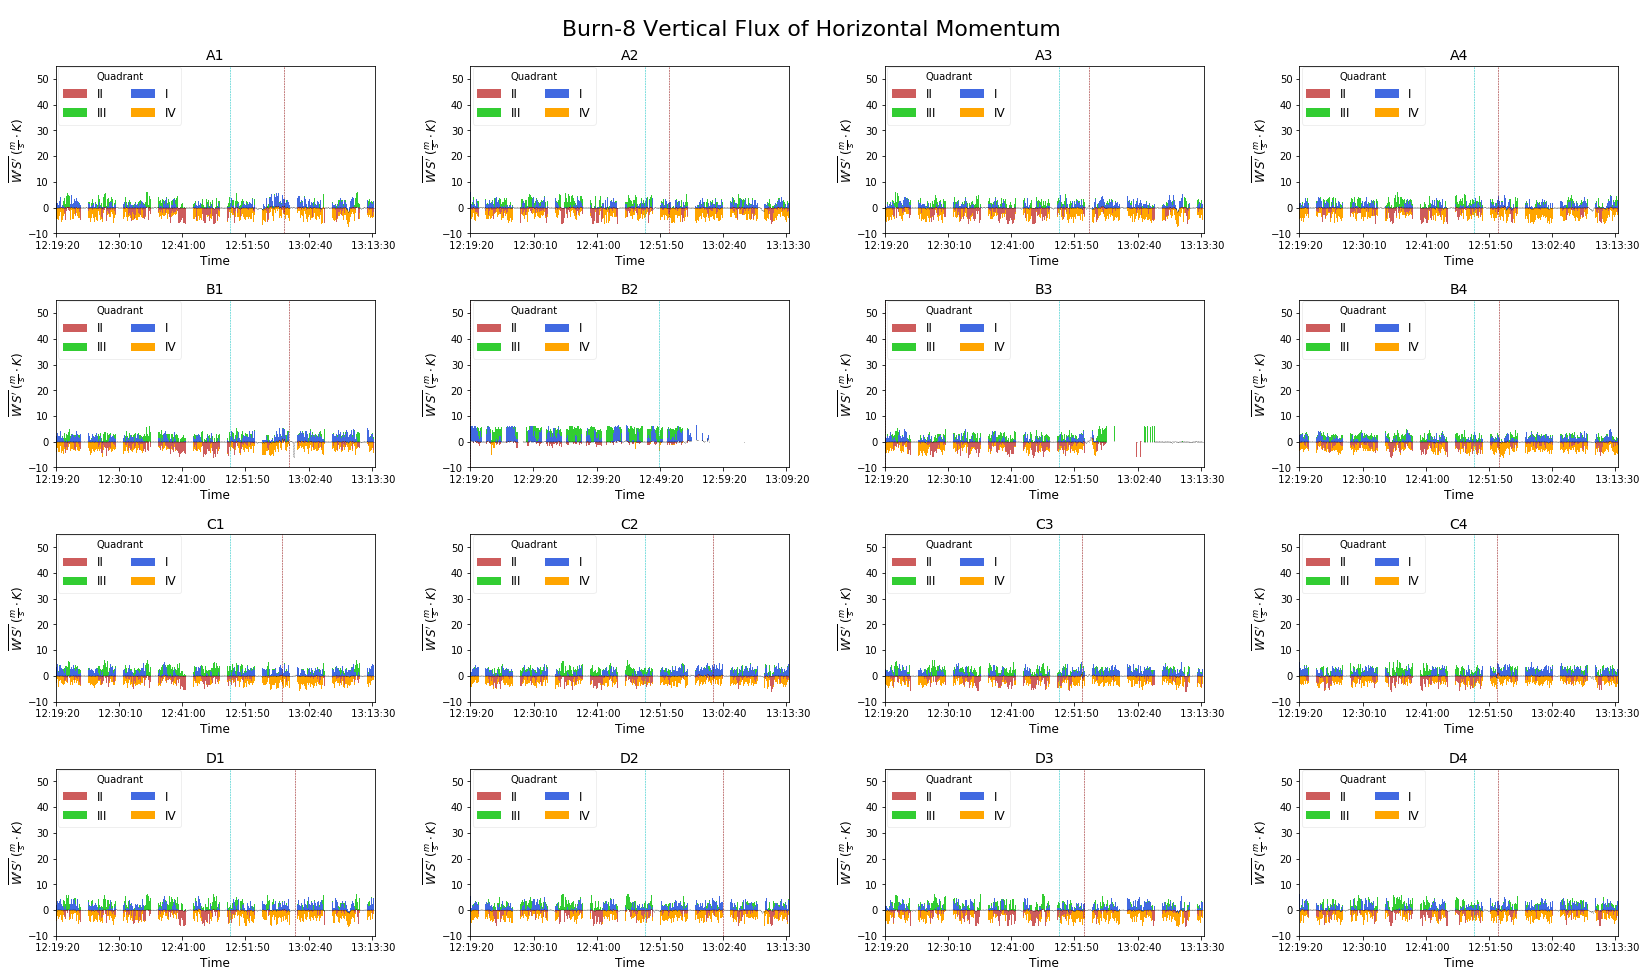

In [41]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-8/sonics/" #79 location
path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-8/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-8/sonics/"  #134 location
grid(path,18000,"Burn-8",seperator = "\t")

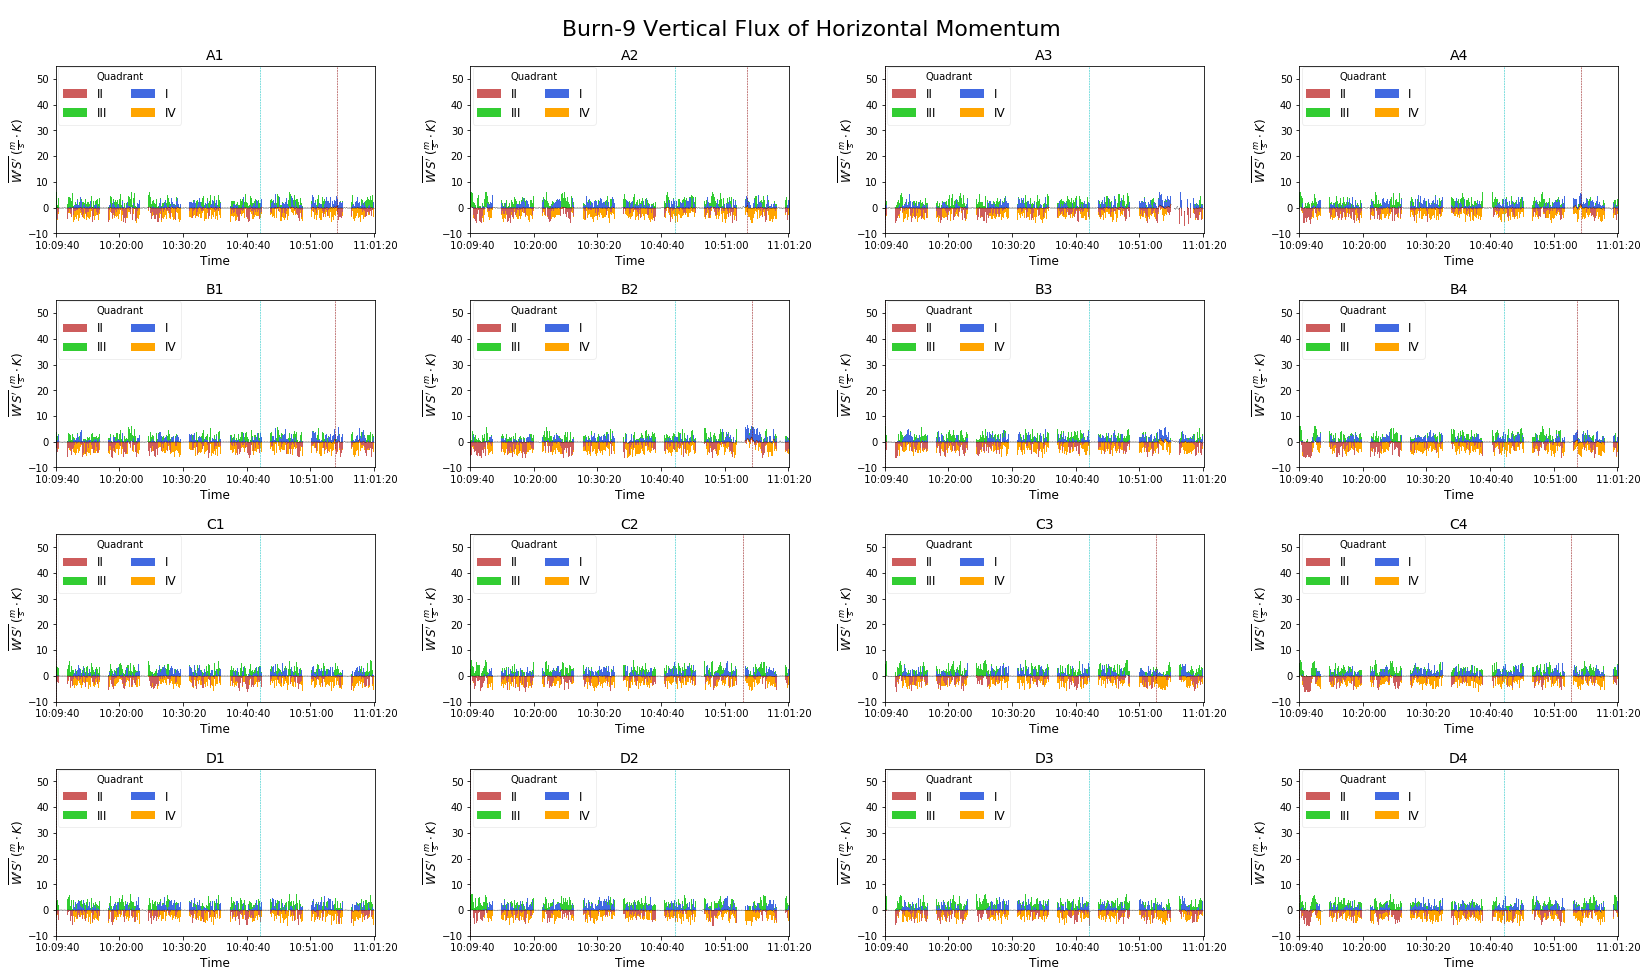

In [42]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-9/sonics/" #79 location
path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-9/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-9/sonics/"  #134 location
grid(path,20000,"Burn-9")#,seperator ="\t")

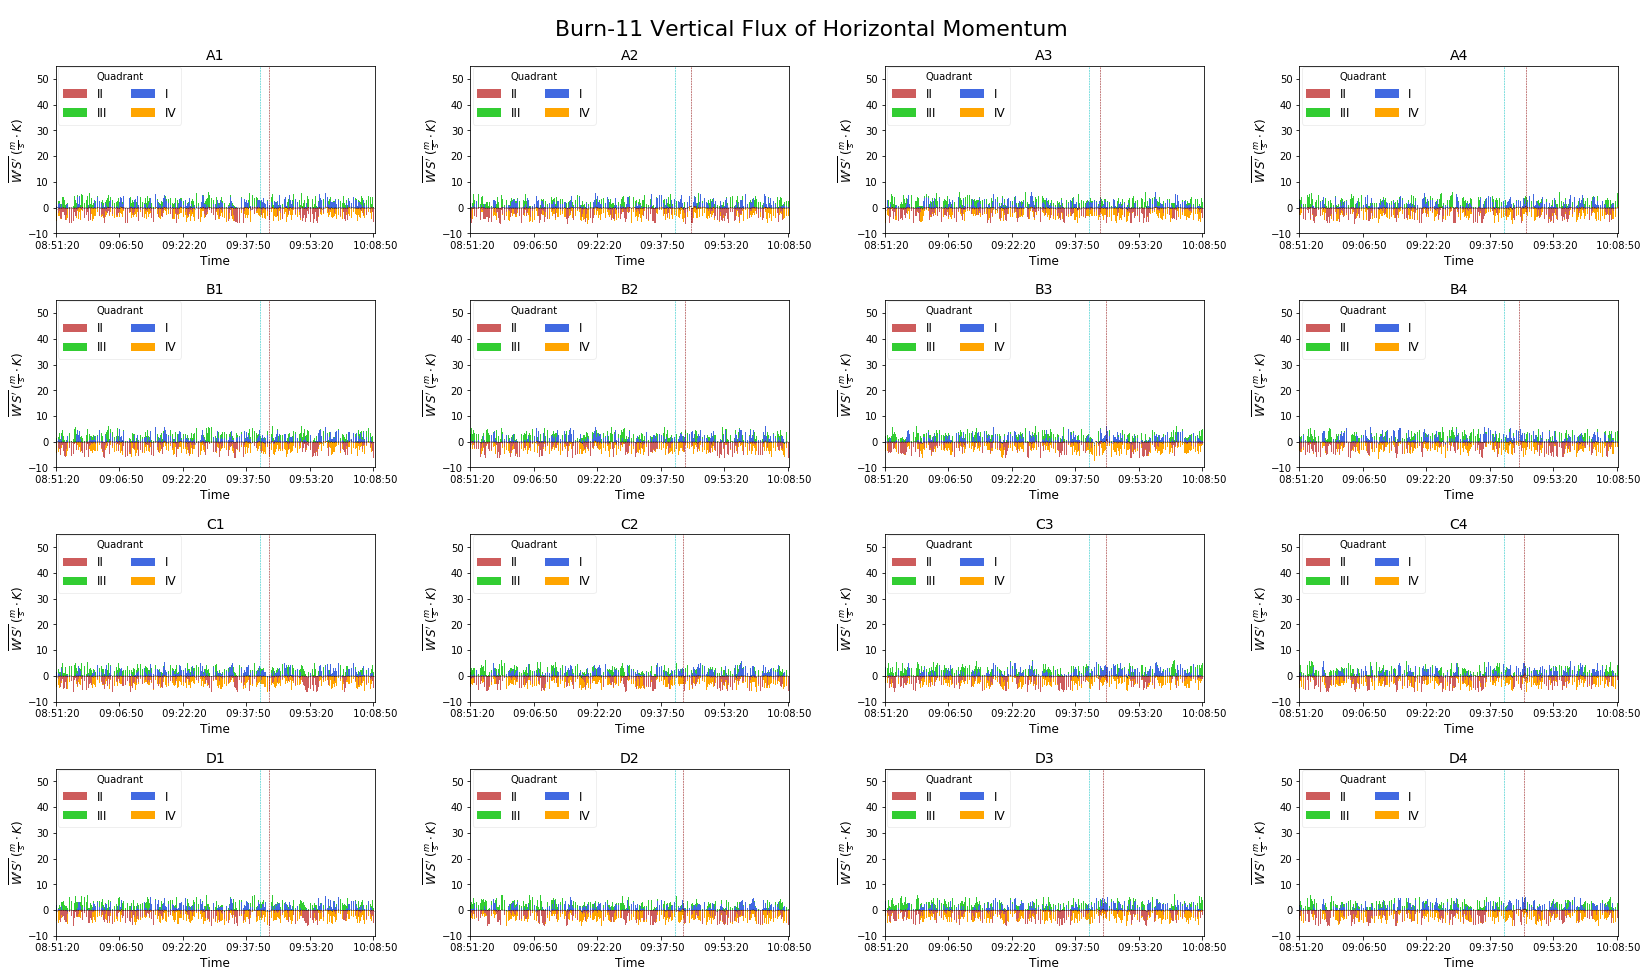

In [43]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-11/sonics/" #79 location
path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-11/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-11/sonics/"  #134 location
grid(path,30000,"Burn-11")

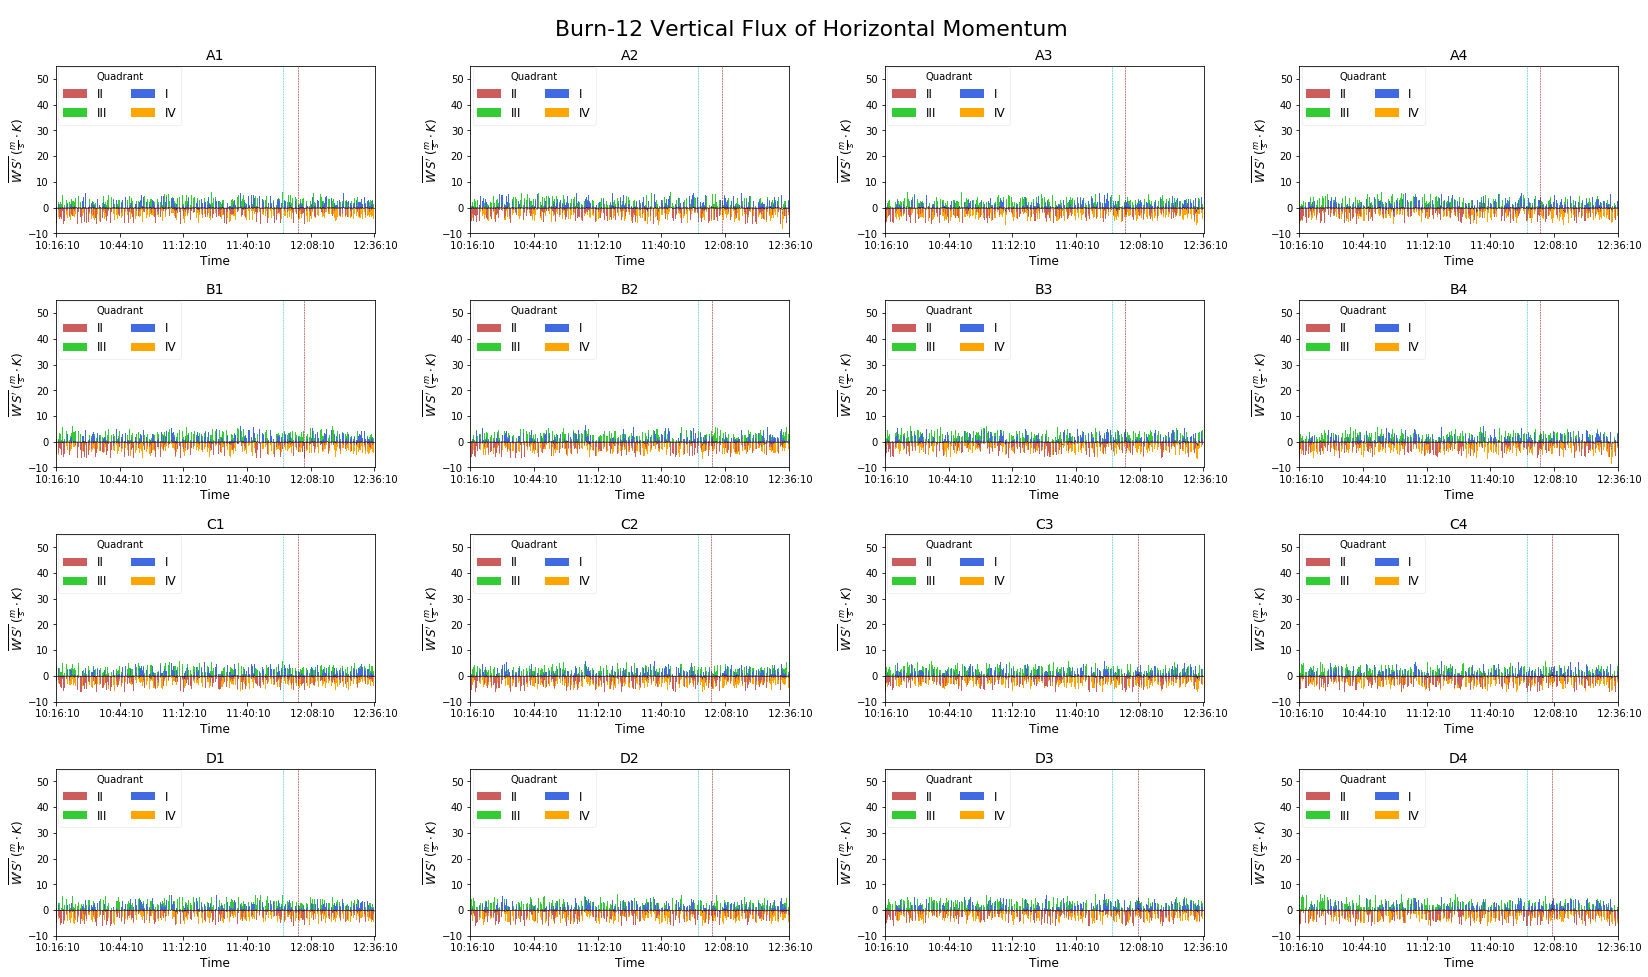

In [44]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-12/sonics/" #79 location
path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-12/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-12/sonics/"  #134 location
grid(path,60000,"Burn-12")

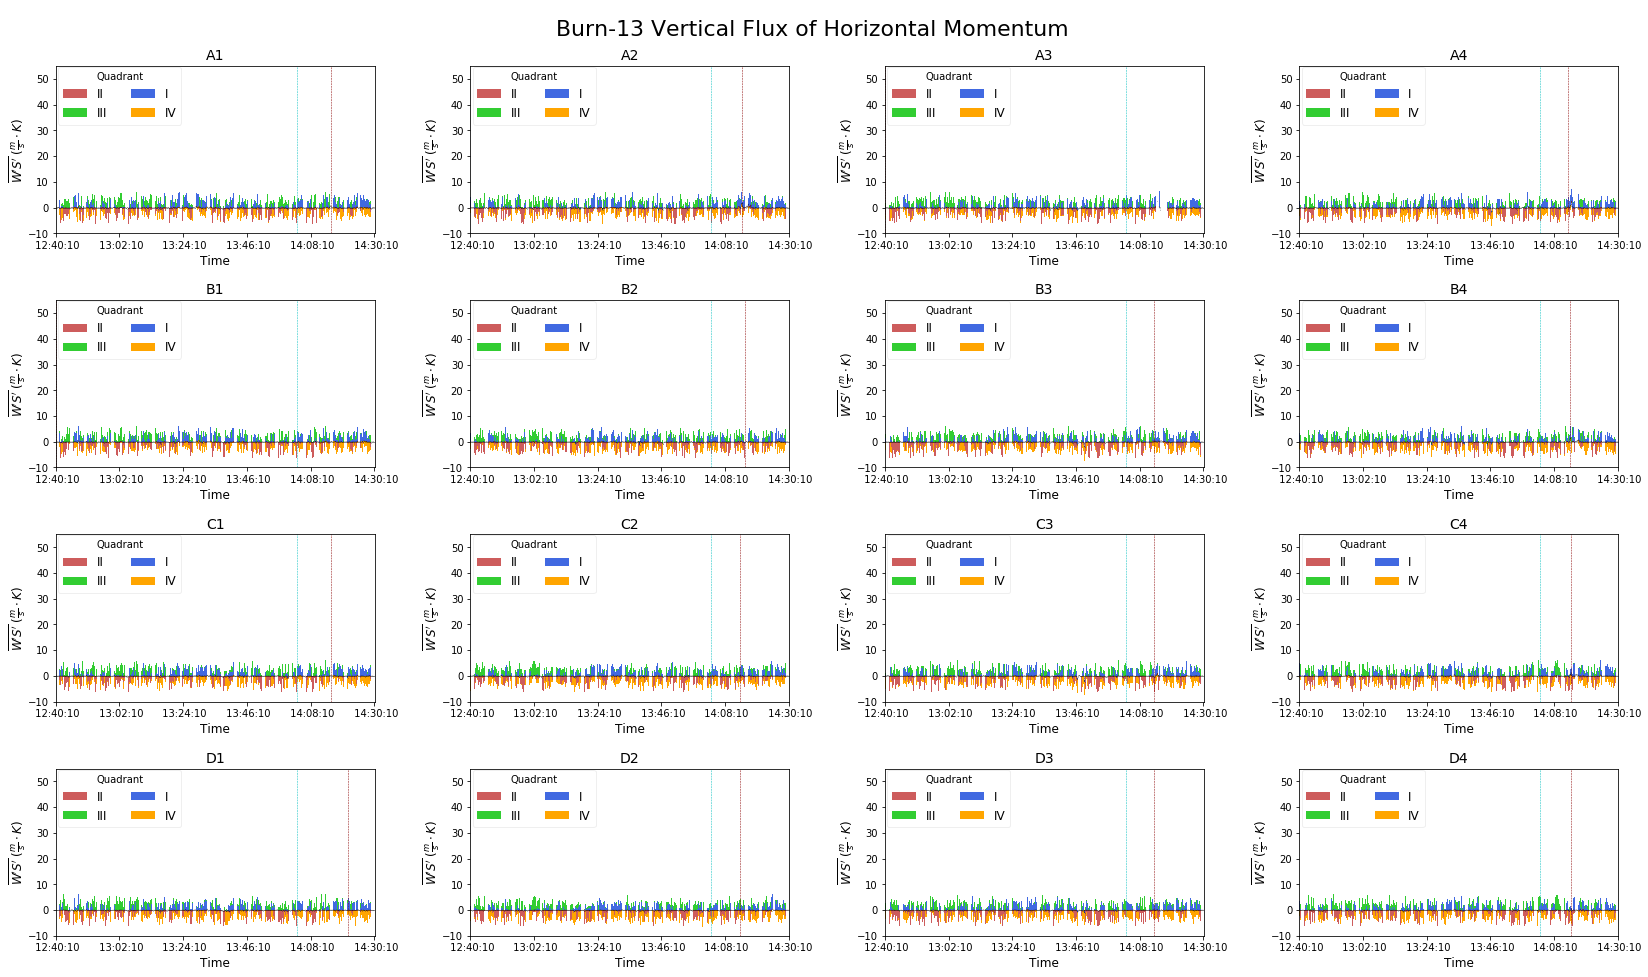

In [45]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/" #79 location
path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location
grid(path,50000,"Burn-13")

In [ ]:
df = pd.read_csv(path + txt_files[2],na_values = ['NAN', "00nan"], sep="\t")  
x,df_plot, q1_list, q2_list, q3_list, q4_list,x_tick_loc, x_tick_label = calculations(df,n)


x_tick_loc, x_tick_label = [], []
for i in range(0,len(df_plot),len(df_plot)//8):
    x_tick_loc.append(i)
    x_tick_label.append(str(df_plot.index[i])[-9:])

plt.figure(figsize=(8,6))

plt.plot(list(df_plot["W'T'"]), marker = "_",linewidth=.5,linestyle = "--", c = "k", markersize=3)
plt.bar(x,q1_list, width = .8,label = "Quad 1",color="royalblue",bottom =list(df_plot["W'T'"]))
plt.bar(x,q2_list,width = .8,label = "Quad 2",color = "indianred",bottom =list(df_plot["W'T'"]))
plt.bar(x,q3_list,width = .8,label = "Quad 3",color = "limegreen",bottom =list(df_plot["W'T'"]))
plt.bar(x,q4_list, width = .8,label = "Quad 4",color = "orange",bottom =list(df_plot["W'T'"]))

plt.xlim(0,250)
plt.legend()
plt.xticks(x_tick_loc,x_tick_label)
#plt.savefig("testplot.png", dpi = 300)

In [ ]:

df_plot.describe()